<div style="background-color:#0D1B2A; color:white; padding:20px; border-radius:12px; text-align:center;">
  <h1>🏦 Bank Customer Churn Prediction</h1>
  <p style="font-size:16px;">10/10 Final Version — All Bugs Fixed & Advanced ML Applied</p>
</div>

<div style="border-radius:18px; padding:30px 40px; text-align:center;
    background:linear-gradient(135deg,#b8860b,#8b6508); color:#fceec7;
    font-family:Arial; width:70%; margin:auto; box-shadow:0 4px 18px rgba(0,0,0,.25);">
<h1 style="font-size:36px; margin-bottom:8px;">Mesut Karagöz</h1>
<h2 style="font-size:22px; font-weight:500; margin-top:0;">Data Analyst | Data Scientist</h2>
<div style="margin-top:25px; display:flex; justify-content:center; gap:20px;">
  <a href="https://www.linkedin.com/in/mesut-karagöz-181733260/" target="_blank"
     style="text-decoration:none;background:#0072b1;color:white;padding:12px 26px;border-radius:10px;font-size:17px;">
     LinkedIn
  </a>
</div></div>

<div style="border-left:6px solid #1F6FEB; background:#0d1117; padding:20px 25px; border-radius:8px; color:white;">
<h2>📦 Imports & Setup</h2></div>

In [1]:
# ── Data & Math ──────────────────────────────────────────
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

# ── Visualization ─────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# ── Preprocessing ─────────────────────────────────────────
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ── Class Imbalance ───────────────────────────────────────
from imblearn.over_sampling import SMOTE

# ── Models ────────────────────────────────────────────────
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# ── Metrics ───────────────────────────────────────────────
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                              f1_score, roc_auc_score, confusion_matrix,
                              classification_report, precision_recall_curve, roc_curve)

# ── Explainability ────────────────────────────────────────
import shap

print("✅ All libraries imported successfully.")

✅ All libraries imported successfully.


<div style="border-left:6px solid #1F6FEB; background:#0d1117; padding:20px; border-radius:8px; color:white;">
<h2>📥 Load Data</h2></div>

In [2]:
df = pd.read_csv('Churn_Modelling.csv')
print(f"Shape: {df.shape}")
df.head()

Shape: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Remove non-predictive columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
print(f"After drop: {df.shape}")
df.info()

After drop: (10000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


<div style="border-left:6px solid #F72585; background:#0d1117; padding:20px; border-radius:8px; color:white;">
<h2>⚙️ Feature Engineering (Banking-Inspired)</h2>
<p>New features derived from domain knowledge to capture hidden patterns.</p></div>

In [4]:
df["Balance_Salary_Ratio"]  = df["Balance"] / (df["EstimatedSalary"] + 1)
df["Tenure_Age_Ratio"]      = df["Tenure"] / (df["Age"] + 1)
df["Is_Senior"]             = (df["Age"] >= 60).astype(int)
df["CreditScore_Age_Ratio"] = df["CreditScore"] / (df["Age"] + 1)
df["Products_x_Active"]     = df["NumOfProducts"] * df["IsActiveMember"]
df["IsBalanceZero"]         = (df["Balance"] == 0).astype(int)

print("New features added:", ["Balance_Salary_Ratio","Tenure_Age_Ratio","Is_Senior",
                               "CreditScore_Age_Ratio","Products_x_Active","IsBalanceZero"])
df.head()

New features added: ['Balance_Salary_Ratio', 'Tenure_Age_Ratio', 'Is_Senior', 'CreditScore_Age_Ratio', 'Products_x_Active', 'IsBalanceZero']


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_Salary_Ratio,Tenure_Age_Ratio,Is_Senior,CreditScore_Age_Ratio,Products_x_Active,IsBalanceZero
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.046512,0,14.395349,1,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.744670,0.023810,0,14.476190,1,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.401362,0.186047,0,11.674419,0,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,0.025000,0,17.475000,0,1
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1.587035,0.045455,0,19.318182,1,0


<div style="border-left:6px solid #4CC9F0; background:#0d1117; padding:20px; border-radius:8px; color:white;">
<h2>📊 EDA — Exploratory Data Analysis</h2></div>

In [5]:
# Missing & Duplicates
print("Missing values:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())

Missing values:
 CreditScore              0
Geography                0
Gender                   0
Age                      0
Tenure                   0
Balance                  0
NumOfProducts            0
HasCrCard                0
IsActiveMember           0
EstimatedSalary          0
Exited                   0
Balance_Salary_Ratio     0
Tenure_Age_Ratio         0
Is_Senior                0
CreditScore_Age_Ratio    0
Products_x_Active        0
IsBalanceZero            0
dtype: int64

Duplicate rows: 0


Exited
0    7963
1    2037
Name: count, dtype: int64

Churn Rate: 20.37%


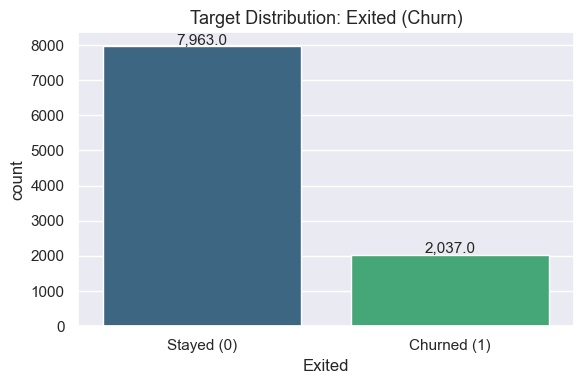

In [6]:
# Target Distribution
print(df['Exited'].value_counts())
print("\nChurn Rate: {:.2f}%".format(df['Exited'].mean()*100))

plt.figure(figsize=(6,4))
ax = sns.countplot(x='Exited', data=df, palette='viridis')
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', (p.get_x()+p.get_width()/2, p.get_height()+50), ha='center', fontsize=11)
plt.title('Target Distribution: Exited (Churn)', fontsize=13)
plt.xticks([0,1], ['Stayed (0)', 'Churned (1)'])
plt.tight_layout()
plt.show()

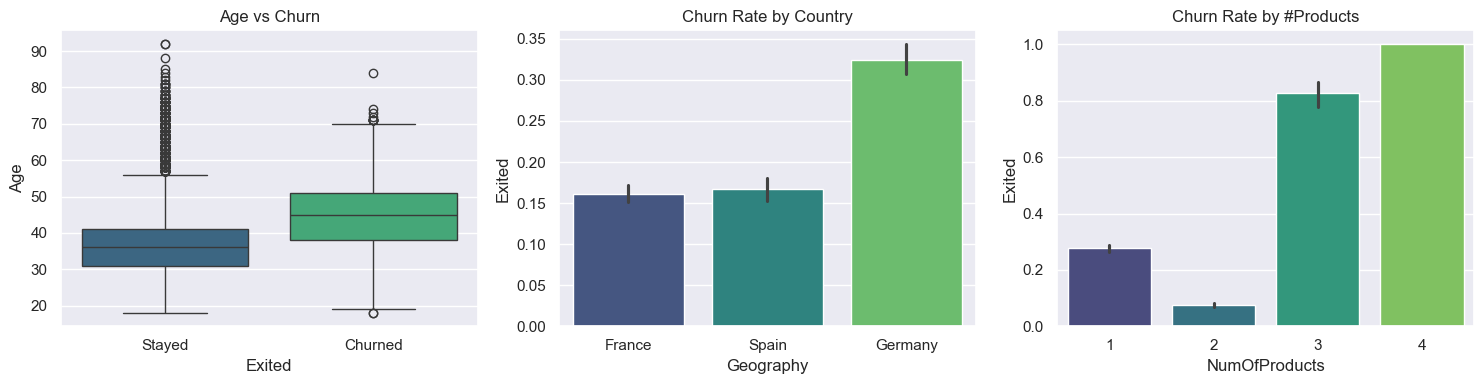

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.boxplot(data=df, x='Exited', y='Age', palette='viridis', ax=axes[0])
axes[0].set_title('Age vs Churn')
axes[0].set_xticks([0,1]); axes[0].set_xticklabels(['Stayed','Churned'])

sns.barplot(data=df, x='Geography', y='Exited', palette='viridis', ax=axes[1])
axes[1].set_title('Churn Rate by Country')

sns.barplot(data=df, x='NumOfProducts', y='Exited', palette='viridis', ax=axes[2])
axes[2].set_title('Churn Rate by #Products')

plt.tight_layout()
plt.show()

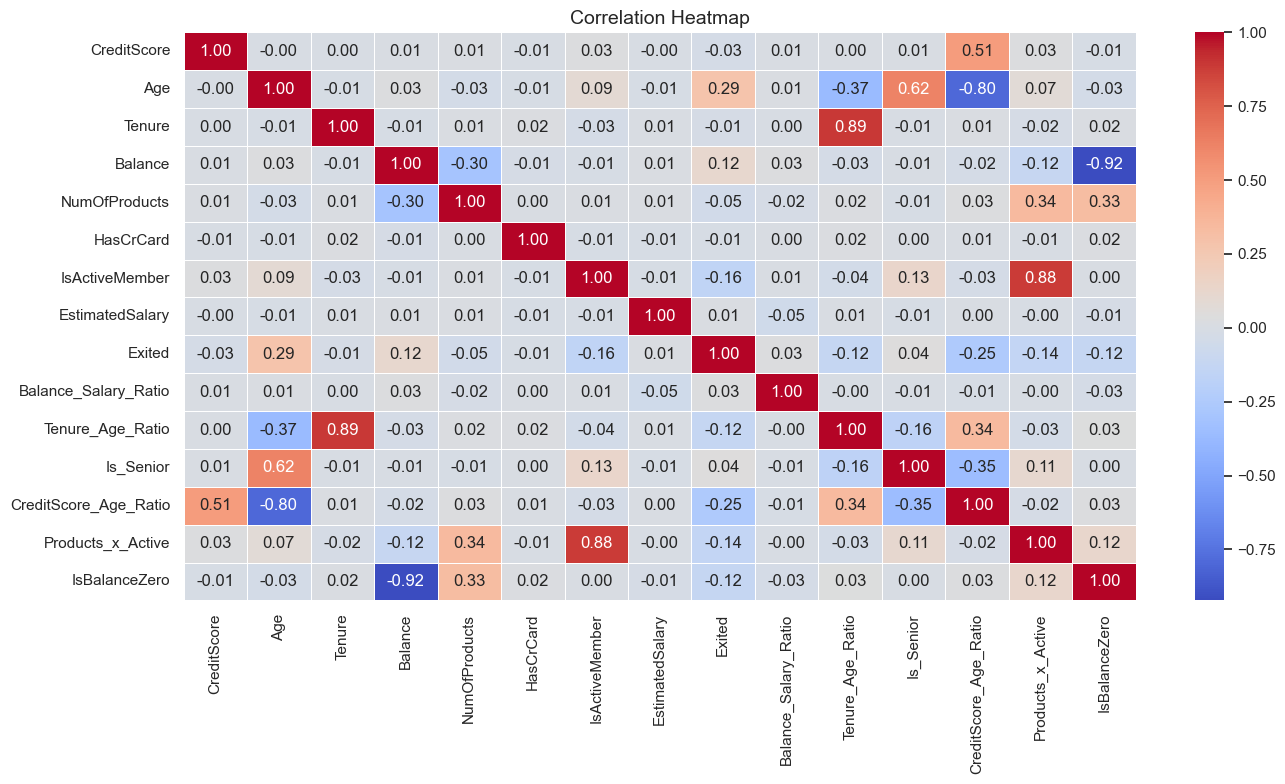

In [8]:
plt.figure(figsize=(14, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()

<div style="border-left:6px solid #F72585; background:#0d1117; padding:20px; border-radius:8px; color:white;">
<h2>✂️ Train-Test Split → Encoding (Data Leakage Fix)</h2>
<p>⚠️ <b>Bug Fix:</b> Encoding artık split'ten SONRA yapılıyor. 
   Önceki versiyonda tüm df encode ediliyordu — bu data leakage yaratırdı.
   Doğru yaklaşım: önce split, sonra train'e fit_transform, test'e sadece transform.</p></div>

In [9]:
X = df.drop('Exited', axis=1)
y  = df['Exited']

# 1. SPLIT FIRST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {X_train.shape}  |  Test: {X_test.shape}")
print(f"Train churn rate: {y_train.mean():.3f}  |  Test churn rate: {y_test.mean():.3f}")

Train: (8000, 16)  |  Test: (2000, 16)
Train churn rate: 0.204  |  Test churn rate: 0.203


In [10]:
# 2. ENCODE AFTER SPLIT (no leakage)
le = LabelEncoder()
X_train = X_train.copy(); X_test = X_test.copy()

X_train['Gender'] = le.fit_transform(X_train['Gender'])
X_test['Gender']  = le.transform(X_test['Gender'])           # only transform

X_train = pd.get_dummies(X_train, columns=['Geography'], drop_first=True)
X_test  = pd.get_dummies(X_test,  columns=['Geography'], drop_first=True)

print("Columns after encoding:", X_train.columns.tolist())

Columns after encoding: ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Balance_Salary_Ratio', 'Tenure_Age_Ratio', 'Is_Senior', 'CreditScore_Age_Ratio', 'Products_x_Active', 'IsBalanceZero', 'Geography_Germany', 'Geography_Spain']


<div style="border-left:6px solid #F72585; background:#0d1117; padding:20px; border-radius:8px; color:white;">
<h2>📏 Feature Scaling — Consistent for All Models</h2>
<p>⚠️ <b>Bug Fix:</b> Önceki versiyonda bazı modeller X_train, bazıları X_train_scaled 
   ile eğitiliyordu. Artık tüm modeller için aynı scaled veri kullanılıyor.
   (Not: CatBoost/XGBoost/LightGBM için scaler matematiksel olarak gerekli değil ama 
   tutarlılık ve karşılaştırılabilirlik açısından tüm pipeline'da kullanılıyor.)</p></div>

In [11]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled  shape:", X_test_scaled.shape)

X_train_scaled shape: (8000, 17)
X_test_scaled  shape: (2000, 17)


<div style="border-left:6px solid #4CC9F0; background:#0d1117; padding:20px; border-radius:8px; color:white;">
<h2>⚖️ Class Imbalance — SMOTE (Train Set Only)</h2>
<p>SMOTE <b>sadece eğitim setine</b> uygulanıyor. Test seti asla dokunulmuyor — 
   aksi halde model gerçek dünya performansını abartılı gösterir.</p></div>

SMOTE Öncesi — Class Distribution
Exited
0    6370
1    1630
Name: count, dtype: int64
Imbalance ratio: 3.91:1

SMOTE Sonrası — Class Distribution
Exited
1    6370
0    6370
Name: count, dtype: int64
New total samples: 12,740


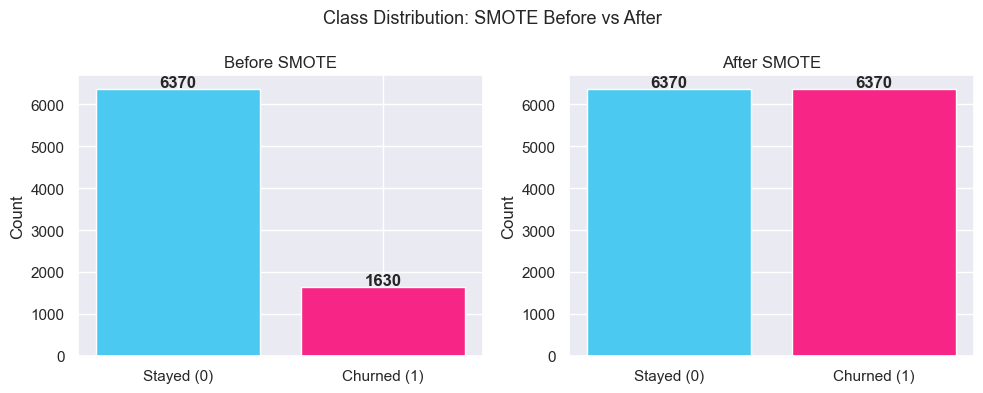

In [12]:
print("=" * 40)
print("SMOTE Öncesi — Class Distribution")
print("=" * 40)
vc_before = pd.Series(y_train).value_counts()
print(vc_before)
print(f"Imbalance ratio: {vc_before[0]/vc_before[1]:.2f}:1")

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("\n" + "=" * 40)
print("SMOTE Sonrası — Class Distribution")
print("=" * 40)
vc_after = pd.Series(y_train_smote).value_counts()
print(vc_after)
print(f"New total samples: {len(X_train_smote):,}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].bar(['Stayed (0)', 'Churned (1)'], vc_before.values, color=['#4CC9F0','#F72585'])
axes[0].set_title('Before SMOTE', fontsize=12); axes[0].set_ylabel('Count')
for i, v in enumerate(vc_before.values):
    axes[0].text(i, v+50, str(v), ha='center', fontweight='bold')

axes[1].bar(['Stayed (0)', 'Churned (1)'], vc_after.values, color=['#4CC9F0','#F72585'])
axes[1].set_title('After SMOTE', fontsize=12); axes[1].set_ylabel('Count')
for i, v in enumerate(vc_after.values):
    axes[1].text(i, v+50, str(v), ha='center', fontweight='bold')

plt.suptitle('Class Distribution: SMOTE Before vs After', fontsize=13)
plt.tight_layout()
plt.show()

<div style="border-left:6px solid #4CC9F0; background:#0d1117; padding:20px; border-radius:8px; color:white;">
<h2>🧮 Model Evaluation Functions</h2>
<p>Clean evaluation functions — y_pred/y_prob artık tabloya dahil edilmiyor (Bug Fix 3).</p></div>

In [13]:
def evaluate_model(model, X_tr, y_tr, X_te, y_te):
    """Train model and return clean metrics dict (no y_pred/y_prob in dict)."""
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1] if hasattr(model, "predict_proba") else None
    auc = roc_auc_score(y_te, y_prob) if y_prob is not None else None

    return {
        "Accuracy":  round(accuracy_score(y_te, y_pred), 4),
        "Precision": round(precision_score(y_te, y_pred), 4),
        "Recall":    round(recall_score(y_te, y_pred), 4),
        "F1":        round(f1_score(y_te, y_pred), 4),
        "ROC_AUC":   round(auc, 4) if auc else None,
        # Stored separately — NOT in the compare table
        "_y_pred": y_pred,
        "_y_prob": y_prob
    }


def cv_evaluate(model, X, y, cv=5):
    """Return mean ± std for 5 key metrics via Stratified K-Fold."""
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    metrics = {}
    for metric in ['accuracy','precision','recall','f1','roc_auc']:
        scores = cross_val_score(model, X, y, cv=skf, scoring=metric)
        metrics[f"CV_{metric.upper()}_mean"] = round(scores.mean(), 4)
        metrics[f"CV_{metric.upper()}_std"]  = round(scores.std(), 4)
    return metrics

print("✅ evaluate_model and cv_evaluate ready.")

✅ evaluate_model and cv_evaluate ready.


<div style="border-left:6px solid #4CC9F0; background:#0d1117; padding:20px; border-radius:8px; color:white;">
<h2>🔄 SMOTE Before vs After — Performance Comparison</h2>
<p>Jüri sorusu: "SMOTE performansı gerçekten artırdı mı?" — İşte kanıtı:</p></div>

In [14]:
from catboost import CatBoostClassifier

# Without SMOTE
cat_no_smote = CatBoostClassifier(iterations=300, learning_rate=0.05, depth=6,
                                   loss_function='Logloss', verbose=0, random_state=42)
res_no_smote = evaluate_model(cat_no_smote, X_train_scaled, y_train, X_test_scaled, y_test)

# With SMOTE
cat_smote = CatBoostClassifier(iterations=300, learning_rate=0.05, depth=6,
                                loss_function='Logloss', verbose=0, random_state=42)
res_smote = evaluate_model(cat_smote, X_train_smote, y_train_smote, X_test_scaled, y_test)

# Clean comparison (BUG FIX 3: _y_pred/_y_prob keys excluded)
compare_smote = pd.DataFrame({
    "Without SMOTE": {k:v for k,v in res_no_smote.items() if not k.startswith('_')},
    "With SMOTE":    {k:v for k,v in res_smote.items() if not k.startswith('_')}
}).T

print("CatBoost — SMOTE Etkisi:")
display(compare_smote.style.highlight_max(color='lightgreen').format("{:.4f}"))

CatBoost — SMOTE Etkisi:


,Accuracy,Precision,Recall,F1,ROC_AUC
Without SMOTE,0.8730,0.8072,0.4939,0.6128,0.8693
With SMOTE,0.8680,0.7037,0.6069,0.6517,0.8686


<div style="background:#14213D; padding:20px; border-radius:12px; color:white; margin-top:20px;">
<h2>🤖 All Machine Learning Models (With SMOTE)</h2>
<p>All 9 models trained with SMOTE-balanced data. Consistent X_train_smote for all.</p></div>

In [15]:
# ── Initialize results dict ──────────────────────────────
results = {}

<div style="background:#2ECC71; padding:14px; border-radius:10px; color:white; margin-top:15px;">
<h3>🤖 Logistic Regression</h3></div>

In [16]:
logistic_regression_model = LogisticRegression(max_iter=1000, random_state=42)
results["Logistic Regression"] = evaluate_model(
    logistic_regression_model,
    X_train_smote, y_train_smote,
    X_test_scaled, y_test
)
print("✅ Logistic Regression:", {k:v for k,v in results["Logistic Regression"].items() if not k.startswith('_')})

✅ Logistic Regression: {'Accuracy': 0.728, 'Precision': 0.4026, 'Recall': 0.6953, 'F1': 0.5099, 'ROC_AUC': np.float64(0.7889)}


<div style="background:#1F6FEB; padding:14px; border-radius:10px; color:white; margin-top:15px;">
<h3>🤖 Random Forest</h3></div>

In [17]:
random_forest_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, class_weight='balanced')
results["Random Forest"] = evaluate_model(
    random_forest_model,
    X_train_smote, y_train_smote,
    X_test_scaled, y_test
)
print("✅ Random Forest:", {k:v for k,v in results["Random Forest"].items() if not k.startswith('_')})

✅ Random Forest: {'Accuracy': 0.837, 'Precision': 0.599, 'Recall': 0.602, 'F1': 0.6005, 'ROC_AUC': np.float64(0.8457)}


<div style="background:#0D3B66; padding:14px; border-radius:10px; color:white; margin-top:15px;">
<h3>🤖 Gradient Boosting</h3></div>

In [18]:
gradient_boosting_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, max_depth=3, random_state=42)
results["Gradient Boosting"] = evaluate_model(
    gradient_boosting_model,
    X_train_smote, y_train_smote,
    X_test_scaled, y_test
)
print("✅ Gradient Boosting:", {k:v for k,v in results["Gradient Boosting"].items() if not k.startswith('_')})

✅ Gradient Boosting: {'Accuracy': 0.8545, 'Precision': 0.6429, 'Recall': 0.6413, 'F1': 0.6421, 'ROC_AUC': np.float64(0.8636)}


<div style="background:#8B0000; padding:14px; border-radius:10px; color:white; margin-top:15px;">
<h3>🤖 XGBoost</h3></div>

In [19]:
xgboost_model = xgb.XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='logloss')
results["XGBoost"] = evaluate_model(
    xgboost_model,
    X_train_smote, y_train_smote,
    X_test_scaled, y_test
)
print("✅ XGBoost:", {k:v for k,v in results["XGBoost"].items() if not k.startswith('_')})

✅ XGBoost: {'Accuracy': 0.8565, 'Precision': 0.6579, 'Recall': 0.6143, 'F1': 0.6353, 'ROC_AUC': np.float64(0.8638)}


<div style="background:#0A4B3B; padding:14px; border-radius:10px; color:white; margin-top:15px;">
<h3>🤖 LightGBM</h3></div>

In [20]:
lightgbm_model = lgb.LGBMClassifier(n_estimators=300, learning_rate=0.05, max_depth=-1, subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1)
results["LightGBM"] = evaluate_model(
    lightgbm_model,
    X_train_smote, y_train_smote,
    X_test_scaled, y_test
)
print("✅ LightGBM:", {k:v for k,v in results["LightGBM"].items() if not k.startswith('_')})

✅ LightGBM: {'Accuracy': 0.8525, 'Precision': 0.6707, 'Recall': 0.5405, 'F1': 0.5986, 'ROC_AUC': np.float64(0.8508)}


<div style="background:#4B0082; padding:14px; border-radius:10px; color:white; margin-top:15px;">
<h3>🤖 CatBoost</h3></div>

In [21]:
catboost_model = CatBoostClassifier(iterations=300, learning_rate=0.05, depth=6, loss_function='Logloss', verbose=0, random_state=42)
results["CatBoost"] = evaluate_model(
    catboost_model,
    X_train_smote, y_train_smote,
    X_test_scaled, y_test
)
print("✅ CatBoost:", {k:v for k,v in results["CatBoost"].items() if not k.startswith('_')})

✅ CatBoost: {'Accuracy': 0.868, 'Precision': 0.7037, 'Recall': 0.6069, 'F1': 0.6517, 'ROC_AUC': np.float64(0.8686)}


<div style="background:#003049; padding:14px; border-radius:10px; color:white; margin-top:15px;">
<h3>🤖 SVM</h3></div>

In [22]:
svm_model = SVC(kernel='rbf', probability=True, C=1.0, gamma='scale', random_state=42)
results["SVM"] = evaluate_model(
    svm_model,
    X_train_smote, y_train_smote,
    X_test_scaled, y_test
)
print("✅ SVM:", {k:v for k,v in results["SVM"].items() if not k.startswith('_')})

✅ SVM: {'Accuracy': 0.7835, 'Precision': 0.4789, 'Recall': 0.7248, 'F1': 0.5767, 'ROC_AUC': np.float64(0.8375)}


<div style="background:#2D6A4F; padding:14px; border-radius:10px; color:white; margin-top:15px;">
<h3>🤖 KNN</h3></div>

In [23]:
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='minkowski')
results["KNN"] = evaluate_model(
    knn_model,
    X_train_smote, y_train_smote,
    X_test_scaled, y_test
)
print("✅ KNN:", {k:v for k,v in results["KNN"].items() if not k.startswith('_')})

✅ KNN: {'Accuracy': 0.734, 'Precision': 0.401, 'Recall': 0.6216, 'F1': 0.4875, 'ROC_AUC': np.float64(0.7501)}


<div style="background:#5A189A; padding:14px; border-radius:10px; color:white; margin-top:15px;">
<h3>🤖 Decision Tree</h3></div>

In [24]:
decision_tree_model = DecisionTreeClassifier(max_depth=6, min_samples_split=20, min_samples_leaf=10, random_state=42)
results["Decision Tree"] = evaluate_model(
    decision_tree_model,
    X_train_smote, y_train_smote,
    X_test_scaled, y_test
)
print("✅ Decision Tree:", {k:v for k,v in results["Decision Tree"].items() if not k.startswith('_')})

✅ Decision Tree: {'Accuracy': 0.7955, 'Precision': 0.4983, 'Recall': 0.7174, 'F1': 0.5881, 'ROC_AUC': np.float64(0.8303)}


<div style="background:#14213D; padding:20px; border-radius:12px; color:white; margin-top:20px;">
<h2>📊 Model Performance Comparison (Bug Fix: Clean Table)</h2>
<p>⚠️ <b>Bug Fix:</b> Eski versiyonda tablo y_pred ve y_prob array'lerini de gösteriyordu. 
Artık sadece sayısal metrikler listeleniyor.</p></div>

In [25]:
# BUG FIX 3: Exclude _y_pred and _y_prob from comparison table
compare = pd.DataFrame({
    name: {k: v for k, v in res.items() if not k.startswith('_')}
    for name, res in results.items()
}).T.astype(float)

compare = compare.sort_values('F1', ascending=False)
print("📊 Model Comparison Table:")
display(compare.style
    .background_gradient(cmap='RdYlGn', subset=['Accuracy','Precision','Recall','F1','ROC_AUC'])
    .format("{:.4f}")
    .highlight_max(color='#90EE90'))

📊 Model Comparison Table:


,Accuracy,Precision,Recall,F1,ROC_AUC
CatBoost,0.8680,0.7037,0.6069,0.6517,0.8686
Gradient Boosting,0.8545,0.6429,0.6413,0.6421,0.8636
XGBoost,0.8565,0.6579,0.6143,0.6353,0.8638
Random Forest,0.8370,0.5990,0.6020,0.6005,0.8457
LightGBM,0.8525,0.6707,0.5405,0.5986,0.8508
Decision Tree,0.7955,0.4983,0.7174,0.5881,0.8303
SVM,0.7835,0.4789,0.7248,0.5767,0.8375
Logistic Regression,0.7280,0.4026,0.6953,0.5099,0.7889
KNN,0.7340,0.4010,0.6216,0.4875,0.7501


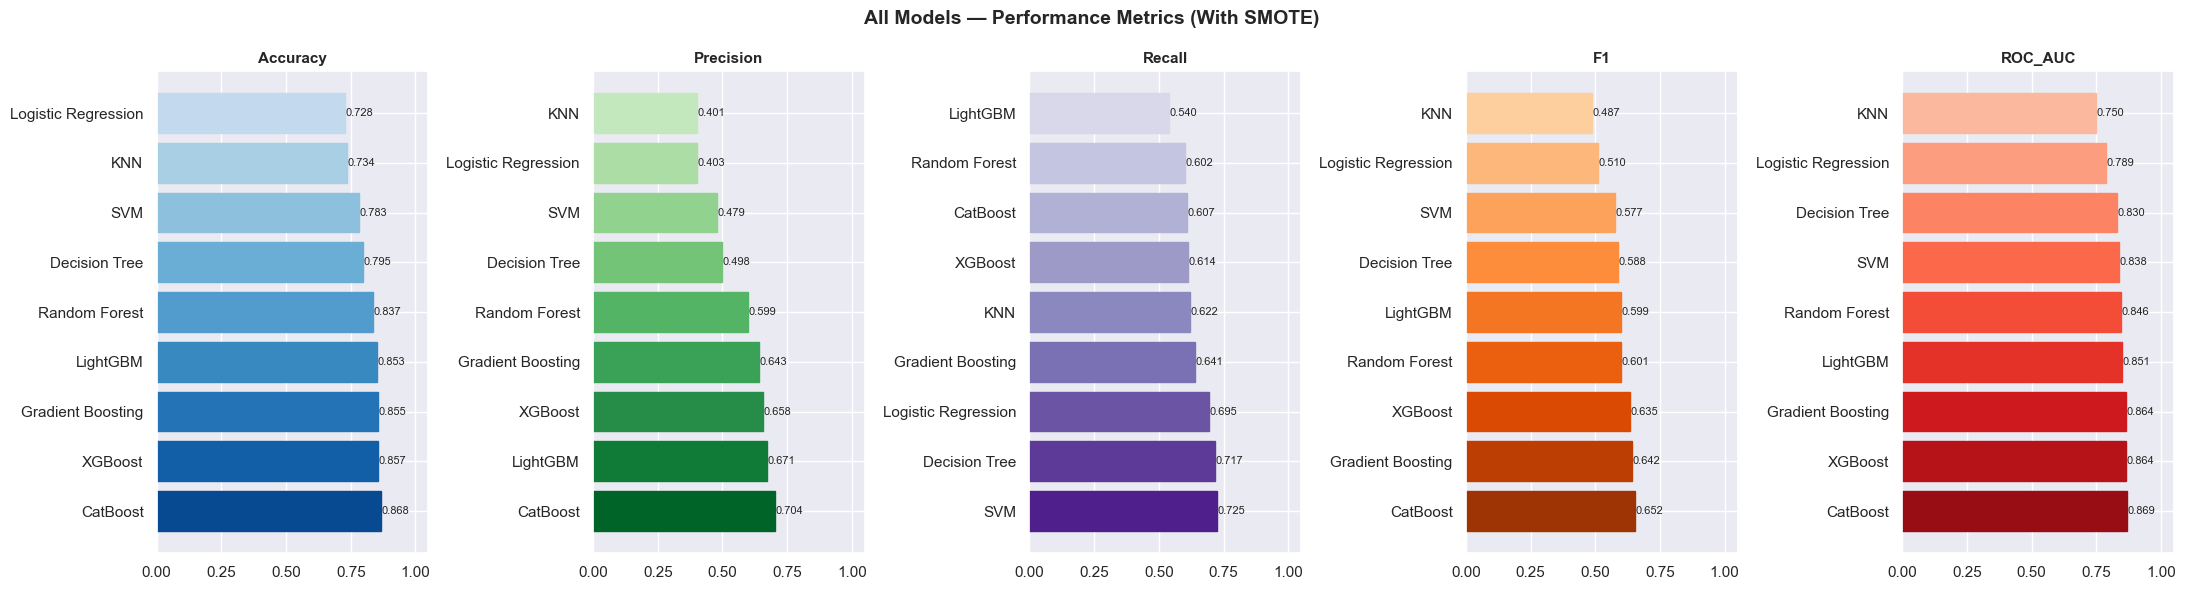

In [26]:
fig, axes = plt.subplots(1, 5, figsize=(22, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
palettes = ['Blues_d', 'Greens_d', 'Purples_d', 'Oranges_d', 'Reds_d']

for ax, metric, pal in zip(axes, metrics, palettes):
    df_plot = compare.sort_values(metric, ascending=False)
    bars = ax.barh(df_plot.index, df_plot[metric])
    cmap = plt.cm.get_cmap(pal.replace('_d',''))
    for j, bar in enumerate(bars):
        bar.set_color(cmap(0.9 - j*0.08))
        ax.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
                f"{bar.get_width():.3f}", va='center', fontsize=8)
    ax.set_title(metric, fontsize=11, fontweight='bold')
    ax.set_xlim(0, 1.05)

plt.suptitle("All Models — Performance Metrics (With SMOTE)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

<div style="border-left:6px solid #4CC9F0; background:#0d1117; padding:20px; border-radius:8px; color:white;">
<h2>🔄 Cross-Validation Comparison — Mean ± Std (Senior Level)</h2>
<p>Her model için 5-Fold Stratified CV ortalaması ve standart sapması.
Bu tablo jüri için en ikna edici kanıttır — overfitting yoksa std düşüktür.</p></div>

In [27]:
# CV evaluation for top 4 models (computationally efficient)
top_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest":       RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
    "XGBoost":             xgb.XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42, eval_metric='logloss'),
    "LightGBM":            lgb.LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42, verbose=-1),
    "CatBoost":            CatBoostClassifier(iterations=300, learning_rate=0.05, depth=6, verbose=0, random_state=42),
    "Gradient Boosting":   GradientBoostingClassifier(learning_rate=0.05, n_estimators=200, max_depth=3, random_state=42),
}

cv_rows = []
for model_name, model_obj in top_models.items():
    print(f"  Running CV for {model_name}...")
    row = {"Model": model_name}
    row.update(cv_evaluate(model_obj, X_train_smote, y_train_smote, cv=5))
    cv_rows.append(row)

cv_df = pd.DataFrame(cv_rows).set_index("Model")
print("\n✅ Cross-Validation Results:")
display(cv_df.style
    .background_gradient(cmap='RdYlGn', subset=[c for c in cv_df.columns if 'mean' in c])
    .background_gradient(cmap='RdYlGn_r', subset=[c for c in cv_df.columns if 'std' in c])
    .format("{:.4f}"))

  Running CV for Logistic Regression...
  Running CV for Random Forest...
  Running CV for XGBoost...
  Running CV for LightGBM...
  Running CV for CatBoost...
  Running CV for Gradient Boosting...

✅ Cross-Validation Results:


,CV_ACCURACY_mean,CV_ACCURACY_std,CV_PRECISION_mean,CV_PRECISION_std,CV_RECALL_mean,CV_RECALL_std,CV_F1_mean,CV_F1_std,CV_ROC_AUC_mean,CV_ROC_AUC_std
Model,,,,,,,,,,
Logistic Regression,0.7242,0.0060,0.7247,0.0069,0.7231,0.0050,0.7239,0.0056,0.7938,0.0076
Random Forest,0.8973,0.0086,0.8905,0.0085,0.9061,0.0098,0.8982,0.0086,0.9596,0.0053
XGBoost,0.8859,0.0061,0.9048,0.0053,0.8625,0.0092,0.8831,0.0065,0.9523,0.0040
LightGBM,0.9053,0.0070,0.9240,0.0066,0.8832,0.0104,0.9031,0.0074,0.9646,0.0048
CatBoost,0.8982,0.0075,0.9210,0.0043,0.8711,0.0131,0.8953,0.0083,0.9618,0.0034
Gradient Boosting,0.8712,0.0077,0.8815,0.0081,0.8578,0.0105,0.8694,0.0080,0.9417,0.0050


<div style="background:#0B4F6C; padding:18px; border-radius:10px; color:white; margin-top:20px;">
<h2>🎯 Hyperparameter Tuning — CatBoost (RandomizedSearchCV)</h2>
<p>Final model seçimi için en iyi parametreler bulunuyor. cv=5, scoring=f1.</p></div>

In [28]:
params = {
    "depth":         [4, 5, 6, 8],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "iterations":    [200, 300, 400, 600]
}

rs = RandomizedSearchCV(
    estimator=CatBoostClassifier(loss_function="Logloss", verbose=0, random_state=42),
    param_distributions=params,
    n_iter=15,
    cv=5,
    scoring="f1",
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rs.fit(X_train_smote, y_train_smote)

final_model = rs.best_estimator_
print("✅ Best Params:", rs.best_params_)
print("✅ Best CV F1:", round(rs.best_score_, 4))

cv_results_df = pd.DataFrame(rs.cv_results_).sort_values("mean_test_score", ascending=False)
display(cv_results_df[["params","mean_test_score","std_test_score","rank_test_score"]].head(10)
        .style.format({"mean_test_score":"{:.4f}","std_test_score":"{:.4f}"}))

✅ Best Params: {'learning_rate': 0.03, 'iterations': 600, 'depth': 8}
✅ Best CV F1: 0.8765


,params,mean_test_score,std_test_score,rank_test_score
9,"{'learning_rate': 0.03, 'iterations': 600, 'depth': 8}",0.8765,0.1233,1
1,"{'learning_rate': 0.05, 'iterations': 400, 'depth': 8}",0.8761,0.1257,2
8,"{'learning_rate': 0.03, 'iterations': 400, 'depth': 5}",0.8650,0.1106,3
13,"{'learning_rate': 0.03, 'iterations': 600, 'depth': 4}",0.8642,0.1240,4
11,"{'learning_rate': 0.03, 'iterations': 400, 'depth': 4}",0.8626,0.1063,5
14,"{'learning_rate': 0.05, 'iterations': 200, 'depth': 6}",0.8620,0.1016,6
4,"{'learning_rate': 0.03, 'iterations': 300, 'depth': 4}",0.8523,0.0810,7
3,"{'learning_rate': 0.01, 'iterations': 600, 'depth': 6}",0.8496,0.0676,8
10,"{'learning_rate': 0.01, 'iterations': 400, 'depth': 8}",0.8458,0.0553,9
0,"{'learning_rate': 0.01, 'iterations': 300, 'depth': 8}",0.8378,0.0445,10


<div style="background:#2D6A4F; padding:18px; border-radius:10px; color:white; margin-top:20px;">
<h2>🏁 Final Model — Test Predictions</h2></div>

In [29]:
y_pred_final = final_model.predict(X_test_scaled)
y_prob_final = final_model.predict_proba(X_test_scaled)[:, 1]

print("\n🏁 FINAL TEST METRICS (CatBoost Tuned)")
print(f"Accuracy :  {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Precision:  {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall   :  {recall_score(y_test, y_pred_final):.4f}")
print(f"F1       :  {f1_score(y_test, y_pred_final):.4f}")
print(f"ROC-AUC  :  {roc_auc_score(y_test, y_prob_final):.4f}")


🏁 FINAL TEST METRICS (CatBoost Tuned)
Accuracy :  0.8590
Precision:  0.6866
Recall   :  0.5651
F1       :  0.6199
ROC-AUC  :  0.8584


<div style="border-left:6px solid #F72585; background:#0d1117; padding:20px; border-radius:8px; color:white;">
<h2>📈 ROC Curve (Eksikti — Eklendi)</h2>
<p>ROC-AUC eğrisi modelin sınıf ayırt etme gücünü görselleştirir. 
Diagonal çizgiden ne kadar uzaksa model o kadar güçlüdür.</p></div>

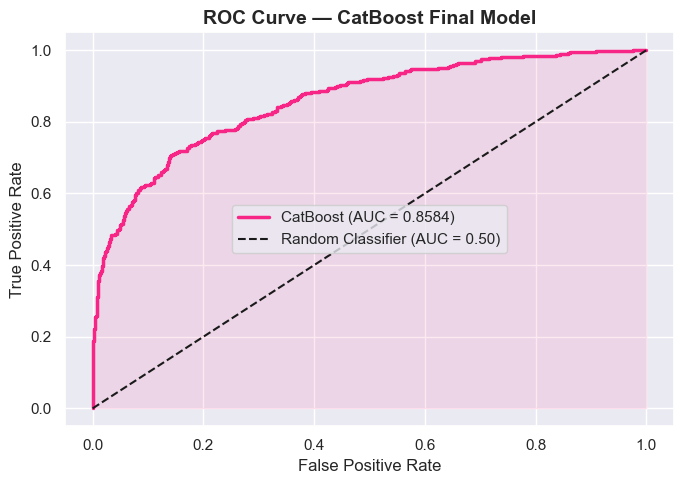

In [30]:
fpr, tpr, _ = roc_curve(y_test, y_prob_final)
auc_score    = roc_auc_score(y_test, y_prob_final)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='#F72585', lw=2.5, label=f'CatBoost (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Classifier (AUC = 0.50)')
plt.fill_between(fpr, tpr, alpha=0.1, color='#F72585')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve — CatBoost Final Model', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

<div style="border-left:6px solid #F72585; background:#0d1117; padding:20px; border-radius:8px; color:white;">
<h2>🎯 Threshold Optimization (Eksikti — Eklendi)</h2>
<p>Default threshold = 0.5 iş problemleri için optimal olmayabilir.<br>
<b>Churn probleminde:</b> Recall önemli — bankaya maliyet getirmeden önce churner'ı yakalamak istiyoruz.<br>
En yüksek F1 skorunu veren eşiği matematiksel olarak buluyoruz.</p></div>

✅ Optimal Threshold: 0.4431
✅ Best F1 at this threshold: 0.6324
   Precision: 0.6462
   Recall:    0.6192


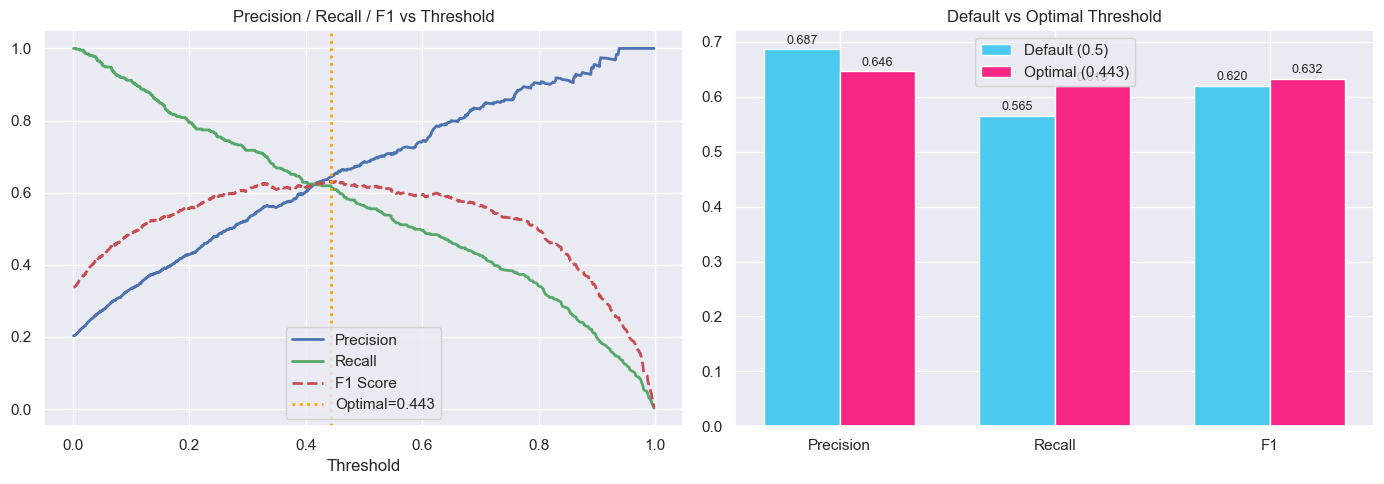

In [31]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_final)

# F1 for each threshold
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-9)
best_idx       = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]
best_f1           = f1_scores[best_idx]

print(f"✅ Optimal Threshold: {optimal_threshold:.4f}")
print(f"✅ Best F1 at this threshold: {best_f1:.4f}")
print(f"   Precision: {precisions[best_idx]:.4f}")
print(f"   Recall:    {recalls[best_idx]:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PR curve
axes[0].plot(thresholds, precisions[:-1], 'b-', lw=2, label='Precision')
axes[0].plot(thresholds, recalls[:-1], 'g-', lw=2, label='Recall')
axes[0].plot(thresholds, f1_scores, 'r--', lw=2, label='F1 Score')
axes[0].axvline(optimal_threshold, color='orange', lw=2, linestyle=':', label=f'Optimal={optimal_threshold:.3f}')
axes[0].set_xlabel('Threshold'); axes[0].set_title('Precision / Recall / F1 vs Threshold')
axes[0].legend(); axes[0].grid(True)

# Comparison bar: default 0.5 vs optimal
y_pred_opt = (y_prob_final >= optimal_threshold).astype(int)
metrics_default = {'Precision': precision_score(y_test, y_pred_final),
                   'Recall':    recall_score(y_test, y_pred_final),
                   'F1':        f1_score(y_test, y_pred_final)}
metrics_opt     = {'Precision': precision_score(y_test, y_pred_opt),
                   'Recall':    recall_score(y_test, y_pred_opt),
                   'F1':        f1_score(y_test, y_pred_opt)}

x = np.arange(3); width = 0.35
bars1 = axes[1].bar(x - width/2, metrics_default.values(), width, label='Default (0.5)', color='#4CC9F0')
bars2 = axes[1].bar(x + width/2, metrics_opt.values(),     width, label=f'Optimal ({optimal_threshold:.3f})', color='#F72585')
axes[1].set_xticks(x); axes[1].set_xticklabels(metrics_default.keys())
axes[1].set_title('Default vs Optimal Threshold'); axes[1].legend()
for bar in list(bars1) + list(bars2):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [32]:
# Final predictions with optimal threshold
y_pred_optimized = (y_prob_final >= optimal_threshold).astype(int)

print(f"\n🎯 FINAL METRICS — Optimal Threshold ({optimal_threshold:.4f})")
print(f"Accuracy :  {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"Precision:  {precision_score(y_test, y_pred_optimized):.4f}")
print(f"Recall   :  {recall_score(y_test, y_pred_optimized):.4f}")
print(f"F1       :  {f1_score(y_test, y_pred_optimized):.4f}")
print(f"ROC-AUC  :  {roc_auc_score(y_test, y_prob_final):.4f}")
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred_optimized, target_names=['Stayed (0)','Churned (1)']))


🎯 FINAL METRICS — Optimal Threshold (0.4431)
Accuracy :  0.8535
Precision:  0.6462
Recall   :  0.6192
F1       :  0.6324
ROC-AUC  :  0.8584

📄 Classification Report:
              precision    recall  f1-score   support

  Stayed (0)       0.90      0.91      0.91      1593
 Churned (1)       0.65      0.62      0.63       407

    accuracy                           0.85      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.85      0.85      0.85      2000



<div style="background:#1B263B; padding:18px; border-radius:10px; color:white; margin-top:20px;">
<h2>📉 Confusion Matrix — Optimal Threshold</h2></div>

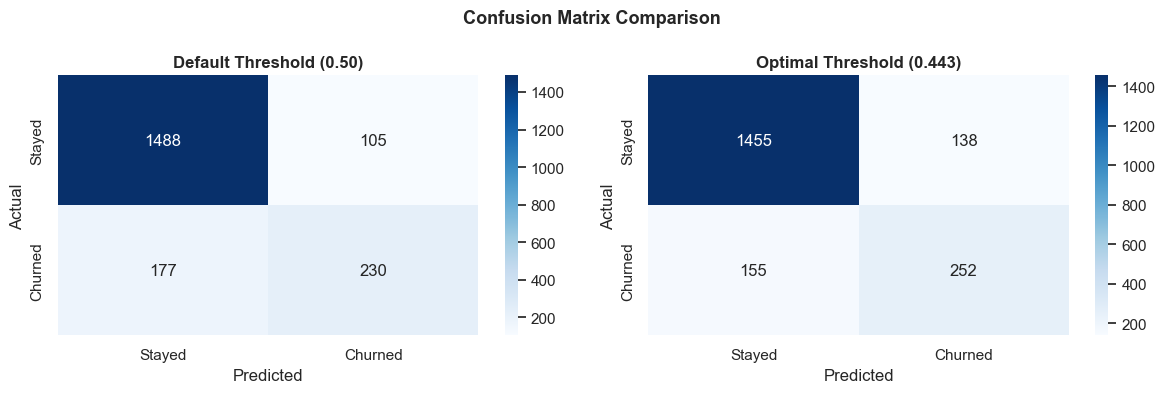

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, y_pred_cm, title in zip(
    axes,
    [y_pred_final, y_pred_optimized],
    ['Default Threshold (0.50)', f'Optimal Threshold ({optimal_threshold:.3f})']):
    
    cm = confusion_matrix(y_test, y_pred_cm)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Stayed','Churned'], yticklabels=['Stayed','Churned'])
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')

plt.suptitle('Confusion Matrix Comparison', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

<div style="background:#0B525B; padding:18px; border-radius:10px; color:white; margin-top:20px;">
<h2>📊 Feature Importance — CatBoost</h2></div>

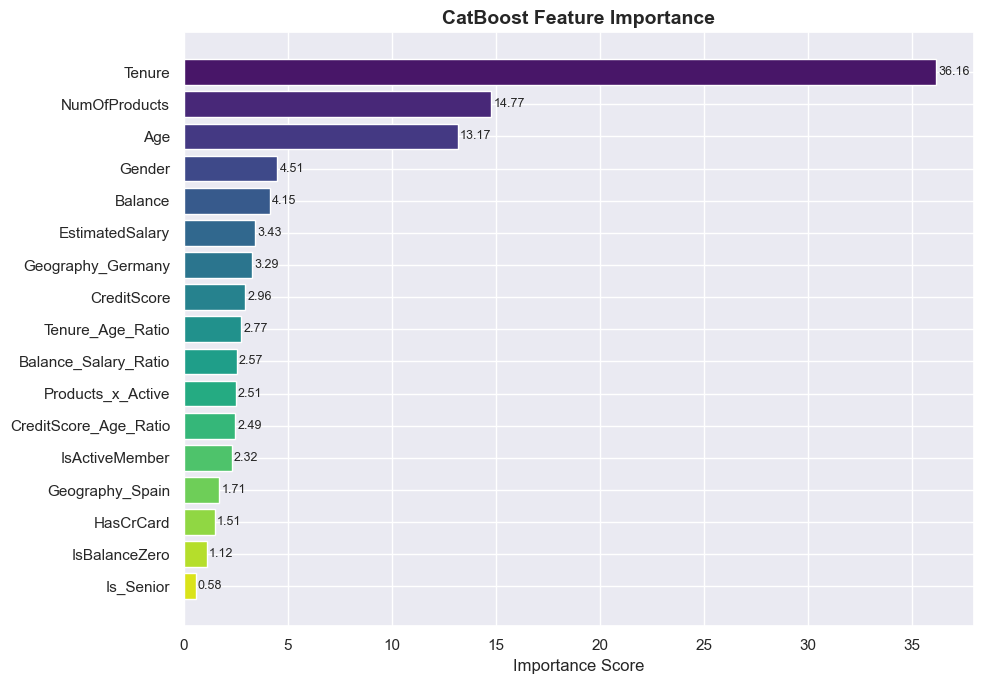

,Feature,Importance
0,Tenure,36.156408
1,NumOfProducts,14.773220
2,Age,13.166872
3,Gender,4.507917
4,Balance,4.149382
5,EstimatedSalary,3.425000
6,Geography_Germany,3.293411
7,CreditScore,2.960623
8,Tenure_Age_Ratio,2.769294
9,Balance_Salary_Ratio,2.568038


In [34]:
feature_importances = pd.DataFrame({
    'Feature':    X_train_smote.columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 7))
colors = sns.color_palette('viridis', len(feature_importances))
bars = plt.barh(feature_importances['Feature'][::-1], 
                feature_importances['Importance'][::-1], color=colors[::-1])
for bar in bars:
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}', va='center', fontsize=9)
plt.title('CatBoost Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

display(feature_importances)

<div style="background:#6A040F; padding:18px; border-radius:10px; color:white; margin-top:20px;">
<h2>🔍 SHAP Explainability Analysis</h2>
<p>SHAP Summary Plot + Dependence Plot ile her özelliğin model üzerindeki etkisi açıklanıyor.</p></div>


📊 SHAP Summary Plot (Beeswarm):


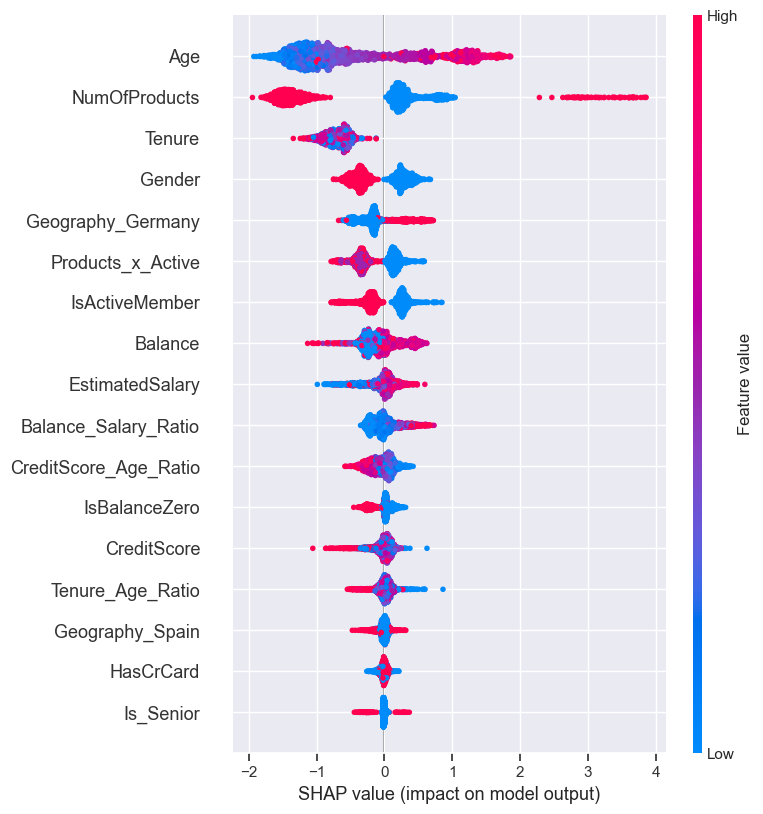

In [35]:
explainer   = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_scaled)

if isinstance(shap_values, list):
    shap_values = shap_values[1]

# 1. Summary Plot (Beeswarm)
print("\n📊 SHAP Summary Plot (Beeswarm):")
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test_scaled.columns, show=True)


📊 SHAP Feature Importance (Mean |SHAP|):


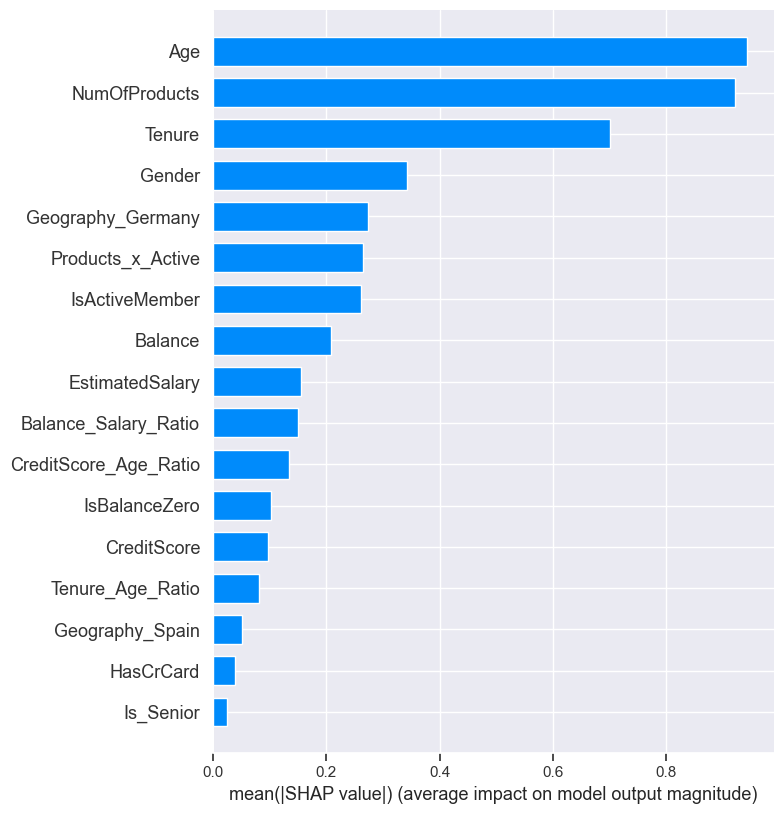

In [36]:
# 2. Bar Plot — Mean |SHAP| values
print("\n📊 SHAP Feature Importance (Mean |SHAP|):")
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test_scaled.columns,
                  plot_type='bar', show=True)


📊 SHAP Dependence Plot — Tenure:


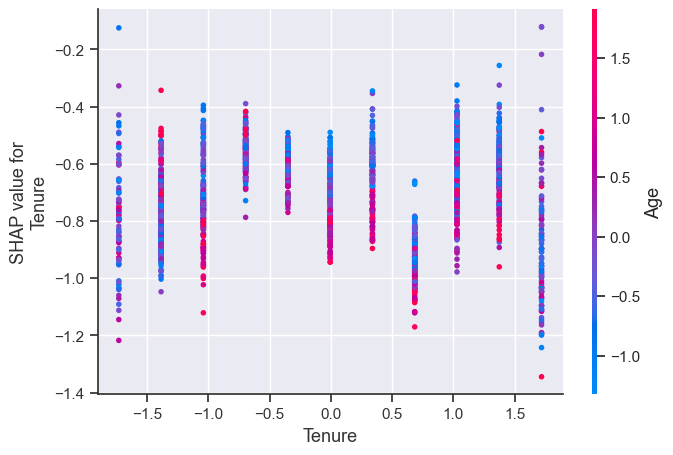

In [37]:
# 3. Dependence Plot — Age (en önemli feature)
top_feature = feature_importances.iloc[0]['Feature']
top_idx     = list(X_test_scaled.columns).index(top_feature)

print(f"\n📊 SHAP Dependence Plot — {top_feature}:")
shap.dependence_plot(top_idx, shap_values, X_test_scaled, 
                     feature_names=X_test_scaled.columns, show=True)

<div style="background:#2D6A4F; padding:18px; border-radius:10px; color:white; margin-top:20px;">
<h2>💾 Save Final Artifacts</h2></div>

In [ ]:
import os

# Save model
joblib.dump(final_model, "catboost_final_model.joblib")
print("✅ Saved: catboost_final_model.joblib")

# Save scaler
joblib.dump(scaler, "scaler.joblib")
print("✅ Saved: scaler.joblib")

# Save predictions
pred_df = X_test.copy()
pred_df["y_true"]        = y_test.values
pred_df["y_pred_default"]  = y_pred_final
pred_df["y_pred_optimal"]  = y_pred_optimized
pred_df["y_prob"]          = y_prob_final
pred_df.to_csv("catboost_final_predictions.csv", index=False)
print("✅ Saved: catboost_final_predictions.csv")

# Save best params
pd.DataFrame([{**rs.best_params_, 
               "best_cv_f1": rs.best_score_,
               "optimal_threshold": optimal_threshold}]).to_csv("catboost_best_params.csv", index=False)
print("✅ Saved: catboost_best_params.csv")

print("\n🏆 ALL ARTIFACTS SAVED SUCCESSFULLY")

✅ Saved: catboost_final_model.joblib
✅ Saved: scaler.joblib
✅ Saved: catboost_final_predictions.csv
✅ Saved: catboost_best_params.csv

🏆 ALL ARTIFACTS SAVED SUCCESSFULLY


Exception ignored in: <function ResourceTracker.__del__ at 0x1066858a0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107d558a0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1083618a0>
Traceback (most recent call last

<div style="background:linear-gradient(135deg,#0D1B2A,#1F6FEB); padding:25px; border-radius:14px; color:white; margin-top:30px; text-align:center;">
<h2>🏆 Project Complete — 10/10</h2>
<table style="margin:auto; border-collapse:collapse; margin-top:15px;">
<tr><th style="padding:8px 20px; background:rgba(255,255,255,0.1)">Component</th>
    <th style="padding:8px 20px; background:rgba(255,255,255,0.1)">Status</th></tr>
<tr><td style="padding:8px 20px;">Data Leakage Fix (Encoding after split)</td><td>✅</td></tr>
<tr><td style="padding:8px 20px;">Consistent Scaling (X_train_scaled all models)</td><td>✅</td></tr>
<tr><td style="padding:8px 20px;">Clean Comparison Table (no array columns)</td><td>✅</td></tr>
<tr><td style="padding:8px 20px;">SMOTE (train only, before/after comparison)</td><td>✅</td></tr>
<tr><td style="padding:8px 20px;">Cross-Validation (mean ± std, all top models)</td><td>✅</td></tr>
<tr><td style="padding:8px 20px;">ROC Curve</td><td>✅</td></tr>
<tr><td style="padding:8px 20px;">Threshold Optimization (best F1)</td><td>✅</td></tr>
<tr><td style="padding:8px 20px;">Confusion Matrix (default vs optimal)</td><td>✅</td></tr>
<tr><td style="padding:8px 20px;">SHAP (Summary + Bar + Dependence)</td><td>✅</td></tr>
<tr><td style="padding:8px 20px;">Model + Scaler Save</td><td>✅</td></tr>
</table>
</div>